In [1]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plotter
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import joblib
data_frame = pd.read_csv("../datasets/train.csv")
data_frame.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [2]:
data_frame = data_frame.drop(columns=["id", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
data_frame

,comment_text,toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \r\n\r\nThat...,0
159568,"Spitzer \r\n\r\nUmm, theres no actual article ...",0
159569,And it looks like it was actually you who put ...,0


In [3]:
def normalize_single_comment(comment) -> str:
    if comment is None:
        return None
    comment = comment.lower()
    comment = re.sub("'", "", comment)
    comment = " ".join(re.findall("[a-z]+", comment))

    if len(comment.strip(" ")) == 0 or len(comment.rstrip()) == 0:
        return None
    else:
        return comment

In [4]:
data_frame["comment_text"] = data_frame["comment_text"].apply(normalize_single_comment)

data_frame

,comment_text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159566,and for the second time of asking when your vi...,0
159567,you should be ashamed of yourself that is a ho...,0
159568,spitzer umm theres no actual article for prost...,0
159569,and it looks like it was actually you who put ...,0


In [5]:
vectorizer = TfidfVectorizer()
toxicData = data_frame.loc[data_frame["toxic"] == 1]
print(len(toxicData))

nontoxicData = data_frame.loc[data_frame["toxic"] == 0][:60000]
print(len(nontoxicData))
data_frame = pd.concat([toxicData, nontoxicData])
x_sample = [ str(x) for x in data_frame["comment_text"]]
y= data_frame["toxic"]
print(len(x_sample))
X = vectorizer.fit_transform(x_sample)
X

15294
60000
75294


<75294x109925 sparse matrix of type '<class 'numpy.float64'>'
	with 3123195 stored elements in Compressed Sparse Row format>

In [6]:
model = LogisticRegression(max_iter=1000)
threshold = 0.30


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size= 0.4, random_state=42)
X_train


<45176x109925 sparse matrix of type '<class 'numpy.float64'>'
	with 1869793 stored elements in Compressed Sparse Row format>

In [8]:
model = model.fit(X_train, y_train)
model

LogisticRegression(max_iter=1000)

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.fill_between(fpr, tpr, alpha=0.2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()


In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels=None):
    """
    Plot a confusion matrix for a binary classification problem.

    Parameters:
    - y_true (array): True labels for the test set
    - y_pred (array): Predicted labels for the test set
    - labels (list): List of label names (default: ['Negative', 'Positive'])

    Returns:
    - None
    """
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set the label names
    if labels is None:
        labels = ['Negative', 'Positive']

    # Normalize the confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create the plot
    fig, ax = plotter.subplots(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=cm, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion matrix')
    plotter.show()

In [12]:
def traditional_test(model) -> float():
        """
        This method tests the trained model on split data and returns the accuracy score of the model.
        The split will be based on vectorizated Trained X as well.
        """
        try:
            predictions = model.predict_proba(X_test)[:, 1]
            predictions = np.where(predictions >= threshold, 1, 0)
            _accuracy = accuracy_score(predictions, y_test)
            _precision, _recall, _F1_score, _ = precision_recall_fscore_support(y_test, predictions, average='binary')
            print("-"*50)
            print("Here are the model metrics: ")
            print("[METRIC] Accuracy Score: %f"%(_accuracy))
            print("[METRIC] Precision: %f"%(_precision))
            print("[METRIC] F1-Score: %f"%(_F1_score))
            print("[METRIC] Recall: %f"%(_recall))
            plot_confusion_matrix(y_test, predictions, labels=["Not Toxic", "Is Toxic"])
            plot_roc_curve(y_test,predictions)
            
        except Exception as e:
            joblib.dump(model,"LRclassifier.joblib")
            print("[ERR] The following error occured while trying to test the model for accuracy! "+str(e))

--------------------------------------------------
Here are the model metrics: 
[METRIC] Accuracy Score: 0.929079
[METRIC] Precision: 0.821622
[METRIC] F1-Score: 0.824458
[METRIC] Recall: 0.827313


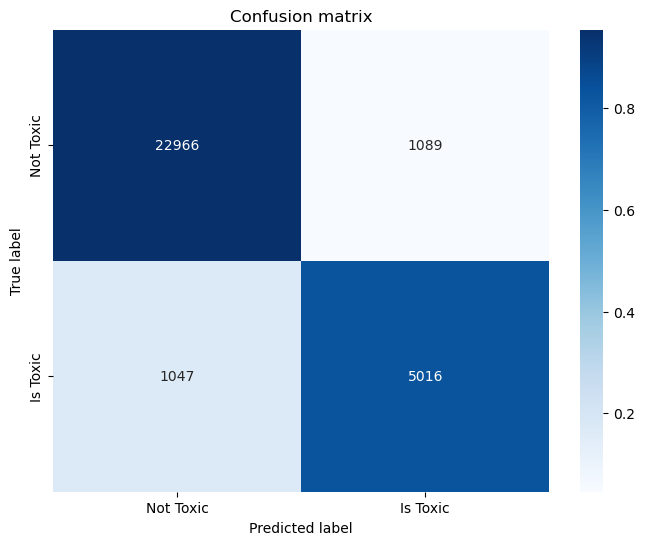

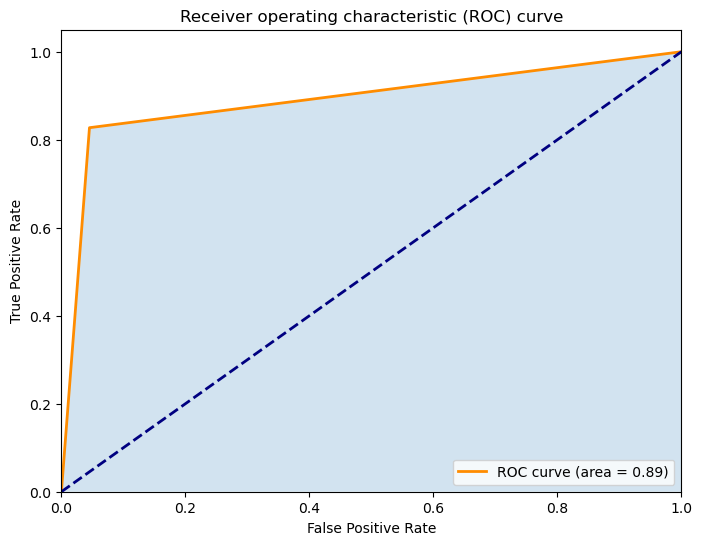

In [13]:
traditional_test(model)

In [101]:
def visualize_data(comments) -> None:
        """
        This method plots a graph for all the unique documents within the dataset.
        """
        
        X = vectorizer.fit_transform(comments).toarray()

        # perform PCA on the word counts
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        plotter.figure(figsize=(8,8))
        # plot the comments on a scatter plot using PCA components 1 and 2
        plotter.scatter(X_pca[:,0], X_pca[:,1], c='r') #,c=['r' if  self.check(i) == 1 else 'b' for i in range(len(X_pca[:,0]))], cmap='coolwarm')
        plotter.xlabel('Feature Space')
        plotter.ylabel('Residual Variability')
        # plotter.axhline(y=X_pca[:, 1].mean(), color='r', linestyle='--', label="Mean RV")
        # plotter.axvline(x=X_pca[:, 0].mean(), color='gray', linestyle='--', label="Mean FS")
        # plotter.axhline(y=np.median(X_pca[:,1]), color='black', linestyle='--', label='Median')
        # plotter.axhline(y=np.mean(X_pca[:,1]), color='gray', linestyle='--', label='Mean')
        plotter.axhline(y=0.15, color='red', linestyle='--', label='RV Threshold')
        plotter.axvline(x =0.13, color='black', linestyle='--', label='SF Threshold')

        line_x = [-0.15, 0.13]
        line_y = [-0.15, -0.15]
        plotter.plot(line_x, line_y, color='black', linestyle='-', linewidth=2)
        line_y = [0.2, 0.2]
        line_x = [-0.2, 0.2]
        plotter.plot(line_x, line_y, color='black', linestyle='-', linewidth=2)
        
        plotter.legend(loc='best')

        plotter.show()

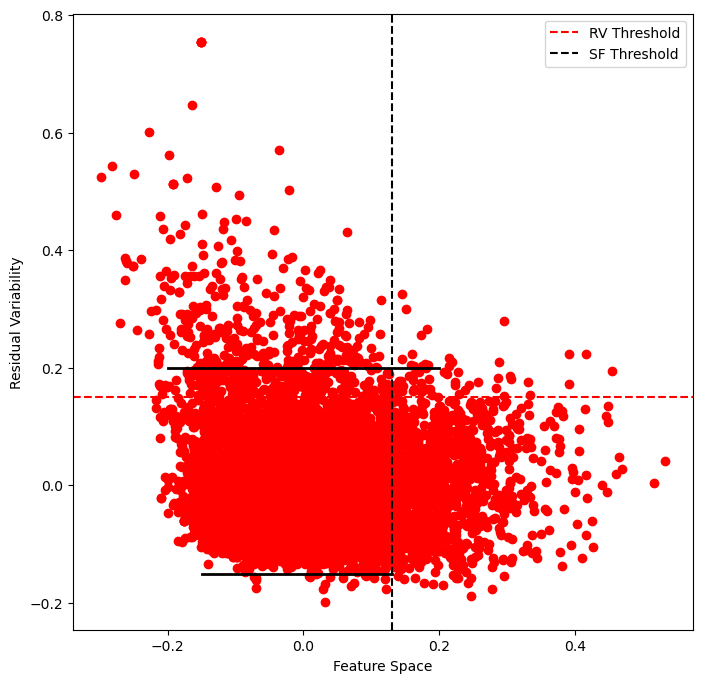

In [110]:
toxicComments = data_frame["comment_text"].loc[data_frame["toxic"] == 1].values[:10000]
visualize_data(toxicComments)